**This notebook measures error propagation in a deep neural network as it receives an adversarial perturbation.**

Steps:

1. Load net trained in `vgg.ipynb`
2. Define attacks and hooks
3. Run net on natural and adversarial examples while recording the activation of layers
4. Calculate change and present

In [1]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

In [28]:
%matplotlib inline
from cleverhans.attacks import FastGradientMethod
from cleverhans.utils_pytorch import convert_pytorch_model_to_tf
from cleverhans.model import CallableModelWrapper
import numpy as np
import tensorflow as tf
import torch
from torchvision import datasets, transforms
from train import cifar_stats
from torch import nn
from itertools import islice
from collections import OrderedDict
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
model_path = '../output/vgg16-trained-on-cifar10.pkl'

In [4]:
attack_func = FastGradientMethod
attack_params = {
    'ord': 2, 
    'eps': 2 # setting this to 3 leads to internal CUDA error
}
attack_params.update({
    # without clipping, would get "NotImplementedError: _project_perturbation currently has clipping hard-coded in."
    # input is normalized to normal distribution, 3 sigmas are enough for clipping
    'clip_min': -3., 'clip_max': 3.,
})
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*cifar_stats)
])
# important to shuffle the data since we'll measure standard deviation
test_data = datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transform_test)

0it [00:00, ?it/s]

100%|█████████▉| 169877504/170498071 [00:29<00:00, 6007673.00it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10


In [5]:
batch_size = 100
num_batches = 20

In [7]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
batches = list(islice(test_loader, 5))

In [8]:
class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [9]:
torch_model = torch.load(model_path, map_location=torch.device('cpu'))

/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrie

In [10]:
torch_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [14]:
class LayerActivationStore(object):

    def __init__(self):
        self.inputs = []
        self.outputs = []
    
    def __call__(self, layer, input, output):
        self.inputs.append(input[0])
        self.outputs.append(output)
        
    def get_input(self):
        return torch.cat(self.inputs)
    
    def get_output(self):
        return torch.cat(self.outputs)
        
class ActivationStore(object):
    
    def __init__(self, net):
        self.layers, self.handles = self.hook_cnn_layers(net)
    
    def hook_cnn_layers(cls, vgg):
        stores, handles = [], []
        for layer in list(vgg.features) + [vgg.classifier]:
            if isinstance(layer, nn.Conv2d):
                store = LayerActivationStore()
                handle = layer.register_forward_hook(store)
                stores.append(store)
                handles.append(handle)
        return stores, handles
    
    def __enter__(self):
        return self

    def __exit__(self, type, value, tb):
        for handle in self.handles:
            handle.remove()

In [77]:
natural_image_activations = ActivationStore(torch_model)
natural_image_predictions = []
with natural_image_activations:
    correct, total = 0, 0
    for xs, ys in batches:
        preds = torch_model(torch.tensor(xs))
        correct += (preds.argmax(axis=1) == ys).float().sum()
        total += ys.shape[0]
        natural_image_predictions.append(preds)
    print('Accuracy: %.4f' % (correct / total))

/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Accuracy: 0.8100


In [15]:
with tf.Session() as sess:
    tf_model_fn = convert_pytorch_model_to_tf(torch_model, out_dims=10)    
    cleverhans_model = CallableModelWrapper(tf_model_fn, output_layer='logits')
    # fix error with SPSA: "ValueError: Tried to convert 'depth' to a tensor and 
    # failed. Error: None values not supported."
    cleverhans_model.nb_classes = 10 

    # important to shuffle the data since we'll measure standard deviation
    x_test_sample, _ = batches[0] # to get the shape of the input
    nchannels, img_rows, img_cols = x_test_sample.shape[1:]
    x = tf.placeholder(tf.float32, shape=(None, nchannels, img_rows, img_cols))
    y = tf.placeholder(tf.int32, shape=(None,))
    attack_model = attack_func(cleverhans_model, sess=sess)
    clean_preds_op = tf_model_fn(x)
    preds_op = tf_model_fn(x)
    # generate adversarial images
    adv_batches = []
    for batch_no, (xs, ys) in enumerate(batches):
        advs = attack_model.generate_np(xs.numpy(), **attack_params)
        adv_batches.append(advs)

[INFO 2020-05-23 18:58:08,449 cleverhans] Constructing new graph for attack FastGradientMethod


In [80]:
adversarial_image_activations = ActivationStore(torch_model)
adversarial_image_predictions = []
with adversarial_image_activations:
    correct, total = 0, 0
    for adv_xs, (_, ys) in zip(adv_batches, batches):
        adv_preds = torch_model(torch.tensor(adv_xs))
        correct += (adv_preds.argmax(axis=1) == ys).float().sum()
        total += ys.shape[0]
        adversarial_image_predictions.append(adv_preds)
    print('Accuracy: %.4f' % (correct / total))

Accuracy: 0.5500


In [18]:
def compute_relative_delta(x, x_new, p=2):
    delta = x_new - x
    norm_func = lambda v: torch.norm(v.reshape(v.shape[0], -1), dim=1, p=p)
    return norm_func(delta) / norm_func(x)

In [22]:
relative_changes = OrderedDict()
# record input
d = compute_relative_delta(natural_image_activations.layers[0].get_input(),
                           adversarial_image_activations.layers[0].get_input())
relative_changes['input'] = d.numpy()
# record activations
for i, (layer_on_natural, layer_on_adv) in enumerate(zip(
        natural_image_activations.layers, adversarial_image_activations.layers)):
    d = compute_relative_delta(layer_on_natural.get_output(), layer_on_adv.get_output())
    name = 'output' if i == len(natural_image_activations.layers)-1 else 'cnn%d' % i
    relative_changes[name] = d.detach().numpy()

In [23]:
relative_changes_df = pd.DataFrame(relative_changes)

In [24]:
relative_changes_long_df = pd.melt(relative_changes_df, 
                                   value_vars=relative_changes_df.columns, 
                                   var_name='layer', value_name='change')
# relative_changes_long_df.sample(5)

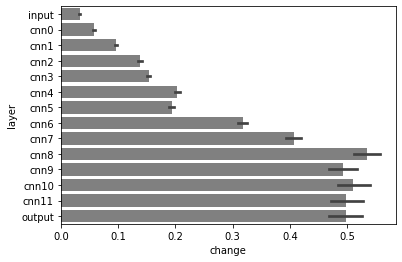

In [25]:
# TODO: change font for better readability
_ = sns.barplot(x='change', y='layer', data=relative_changes_long_df, color='gray')

# Display some examples

In [120]:
xs, ys = batches[0]
preds_raw = natural_image_predictions[0].argmax(axis=1)
adv_preds_raw = adversarial_image_predictions[0].argmax(axis=1)
indices = (preds_raw == ys) & (adv_preds_raw != ys)
natural_images = xs[indices]
adversarial_images = torch.tensor(adv_batches[0])[indices]
natural_preds = preds_raw[indices]
adv_preds = adv_preds_raw[indices]
delta = adversarial_images - natural_images

In [121]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [122]:
def show_image(ax, imgs, i=None):
    i = np.random.randint(len(imgs)) if i is None else i
    img = imgs[i].permute(1,2,0)
    means, stds = cifar_stats
    means = torch.tensor(means).reshape(1,1,3)
    stds = torch.tensor(stds).reshape(1,1,3)
    img_unnormalized = img * stds + means
    ax.imshow(img_unnormalized.clamp(0, 1))
    
def show_image_grid(imgs, preds=None):
    n = 3
    _, axes = plt.subplots(n, n, figsize=(8, 8))
    for i in range(n):
        for j in range(n):
            ax = axes[i][j]
            ex = i*n+j
            show_image(ax, imgs, ex)
            title = ' '
            if preds is not None:
                title = 'prediction: %s' % classes[preds[ex]]
            ax.set_title(title, fontsize=18)
            ax.axis('off')

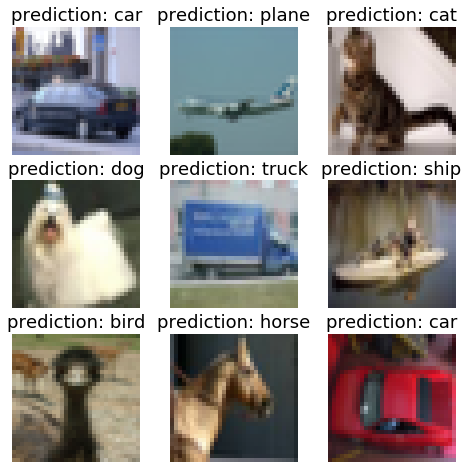

In [123]:
show_image_grid(natural_images, natural_preds)

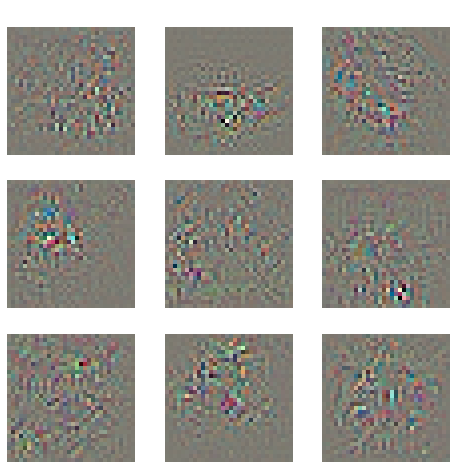

In [124]:
show_image_grid(delta*10)

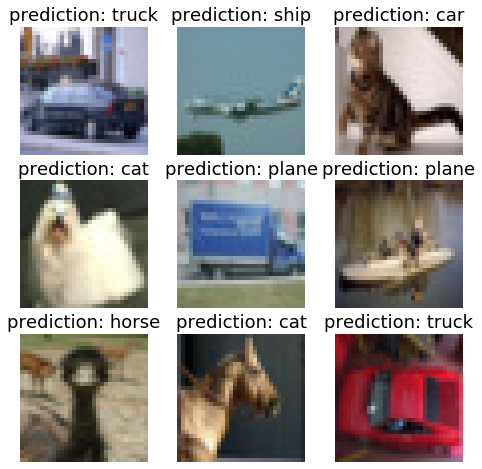

In [125]:
show_image_grid(adversarial_images, adv_preds)